# Install Libraries

In [ ]:
!pip install simpletransformers
!pip install --upgrade huggingface_hub

# Import dataset: en (English)

In [ ]:
from google.colab import drivev
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

import pickle
with open("dict_dataset.pkl", "rb") as myFile:
    dict_dataset = pickle.load(myFile)

train_dataset = dict_dataset['train']
val_dataset = dict_dataset['validation']
test_dataset = dict_dataset['test']

Mounted at /content/drive


# Define functions

In [ ]:
# Postprocess the tokens
def postprocess(token):
    with_space = False
    with_break = False
    if token.startswith('Ġ'):
        with_space = True
        token = token[1:]
        # print(token)
    elif token.startswith('â'):
        token = ' '
    elif token.startswith('Ċ'):
        token = ' '
        with_break = True

    token = '-' if token.startswith('â') else token
    token = '“' if token.startswith('ľ') else token
    token = '”' if token.startswith('Ŀ') else token
    token = "'" if token.startswith('Ļ') else token

    return token

In [ ]:
import numpy as np

# Obtain the list of predicted tokens and their respective probabilities of each token
def check_probabilities(in_text, tokenizer, model, topk = 100):
    # Process input
    token_ids = tokenizer(in_text, return_tensors='pt').data['input_ids'][0]
    token_ids = torch.concat([start_token, token_ids])

    # Forward through the model
    output = model(token_ids.to(device))
    all_logits = output.logits[:-1].detach().squeeze()
    print(all_logits.shape)

    # Construct target and pred
    all_probs = torch.softmax(all_logits, dim=1)

    y = token_ids[1:]
    # Sort the predictions for each timestep
    sorted_preds = torch.argsort(all_probs, dim=1, descending=True).cpu()
    # [(pos, prob), ...]
    real_topk_pos = list(
        [int(np.where(sorted_preds[i] == y[i].item())[0][0])
          for i in range(y.shape[0])])
    real_topk_probs = all_probs[np.arange(
        0, y.shape[0], 1), y].data.cpu().numpy().tolist()
    real_topk_probs = list(map(lambda x: round(x, 5), real_topk_probs))

    real_topk = list(zip(real_topk_pos, real_topk_probs))
    # [str, str, ...]
    bpe_strings = tokenizer.convert_ids_to_tokens(token_ids[:])

    bpe_strings = [postprocess(s) for s in bpe_strings]

    topk_prob_values, topk_prob_inds = torch.topk(all_probs, k=topk, dim=1)

    pred_topk = [list(zip(tokenizer.convert_ids_to_tokens(topk_prob_inds[i]),
                          topk_prob_values[i].data.cpu().numpy().tolist()
                          )) for i in range(y.shape[0])]
    pred_topk = [[(postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]


    payload = {'bpe_strings': bpe_strings,
                'real_topk': real_topk,
                'pred_topk': pred_topk}
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return payload

In [ ]:
# Highlight each token in the text and classify it with respect to the given threshold (ratio)
def color_text(text, payload, ratio):
    colored_text = ''
    l = len(text)
    count = {}
    count['green'] = 0
    count['yellow'] = 0
    count['purple'] = 0
    count['red'] = 0
    pred = 0 # default class: generated

    # Highlight of colors
    for word in range(len(text)):
        if 0 <= payload['real_topk'][word][0] < 10:
            colored_text += '\033[48;2;204;255;204m' + text[word] + '\033[0m' + ' '  # Pastel green
            count['green'] += 1
        elif 10 <= payload['real_topk'][word][0] < 100:
            colored_text += '\033[48;2;255;255;153m' + text[word] + '\033[0m' + ' '  # Pastel yellow
            count['yellow'] += 1
        elif 100<= payload['real_topk'][word][0] < 1000:
            colored_text += '\033[48;2;204;153;255m' + text[word] + '\033[0m' + ' '  # Pastel purple
            count['purple'] += 1
        elif payload['real_topk'][word][0] > 1000:
            colored_text += '\033[48;2;255;153;153m' + text[word] + '\033[0m' + ' '  # Pastel red
            count['red'] += 1
    # print('Count: ', count['green'], 'Text length: ', l)

    # Classification
    if count['green'] > l*ratio:
      return colored_text, pred
    else:
      pred = 1 # human
      return colored_text, pred

In [ ]:
# Main function
def classify_text(in_text, tokenizer, model, ratio):
  # Tokenize input text
  tokens = tokenizer.tokenize(in_text)

  # Filter out special tokens and convert tokens to string
  text = [postprocess(token) for token in tokens if not tokenizer.special_tokens_map.get(token)]

  # Obtain probabilities
  payload = check_probabilities(in_text, tokenizer, model)

  # Color the text
  colored_text, pred = color_text(text, payload, ratio)

  # print('Pred: ', pred)
  # print(colored_text)
  return colored_text, pred

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute evaluation metrics
def test_model(test_dataset, tokenizer, model, ratio):
  # All texts
  texts = test_dataset['text']
  real_labels = test_dataset['label'] # real labels

  pred_labels = []
  for text in texts:
      colored_text, pred = classify_text(text, tokenizer, model, ratio)
      pred_labels.append(pred)

  # Calculate TP, FP, FN counts
  TP = sum(pred == 1 and real == 1 for pred, real in zip(pred_labels, real_labels))
  FP = sum(pred == 1 and real == 0 for pred, real in zip(pred_labels, real_labels))
  FN = sum(pred == 0 and real == 1 for pred, real in zip(pred_labels, real_labels))

  # Calculate precision, recall, and F1-score
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * (precision * recall) / (precision + recall)

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)

  # Show the precision, recall, and f1-score of the predictions
  LABELS = ['generated', 'human']  # 'generated': 0, 'human': 1
  print(classification_report(y_true=real_labels, y_pred=pred_labels, target_names=LABELS, digits=4))

  # Confusion Matrix
  print(confusion_matrix(real_labels, pred_labels))
  disp=ConfusionMatrixDisplay.from_predictions(real_labels, pred_labels, cmap=plt.cm.Blues)

# GPT-2-Small

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
tokenizer_gpt2 = AutoTokenizer.from_pretrained("gpt2")
gpt2.eval()
# Define start token
start_token = tokenizer_gpt2(tokenizer_gpt2.bos_token, return_tensors='pt').data['input_ids'][0]

# Threshold values
for ratio in [1/4, 1/3, 1/2]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2, gpt2, ratio)

RATIO:  0.25
Precision: 1.0
Recall: 0.003758691975192633
F1-score: 0.007489234225800412
              precision    recall  f1-score   support

   generated     0.5135    1.0000    0.6786     11190
       human     1.0000    0.0038    0.0075     10642

    accuracy                         0.5144     21832
   macro avg     0.7567    0.5019    0.3430     21832
weighted avg     0.7506    0.5144    0.3514     21832

[[11190     0]
 [10602    40]]
RATIO:  0.3333333333333333
Precision: 0.963963963963964
Recall: 0.010054501033640292
F1-score: 0.019901422858737094
              precision    recall  f1-score   support

   generated     0.5150    0.9996    0.6798     11190
       human     0.9640    0.0101    0.0199     10642

    accuracy                         0.5173     21832
   macro avg     0.7395    0.5048    0.3498     21832
weighted avg     0.7338    0.5173    0.3581     21832

[[11186     4]
 [10535   107]]
RATIO:  0.5
Precision: 0.9622815087396505
Recall: 0.09828979515128736
F1-score: 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.6666666666666666
Precision: 0.8681293302540416
Recall: 0.7064461567374554
F1-score: 0.7789866335094809
              precision    recall  f1-score   support

   generated     0.7628    0.8979    0.8249     11190
       human     0.8681    0.7064    0.7790     10642

    accuracy                         0.8046     21832
   macro avg     0.8155    0.8022    0.8019     21832
weighted avg     0.8142    0.8046    0.8025     21832

[[10048  1142]
 [ 3124  7518]]
RATIO:  0.75
Precision: 0.6761216780436079
Recall: 0.9586543882728811
F1-score: 0.7929734561423962
              precision    recall  f1-score   support

   generated     0.9347    0.5633    0.7029     11190
       human     0.6761    0.9587    0.7930     10642

    accuracy                         0.7560     21832
   macro avg     0.8054    0.7610    0.7480     21832
weighted avg     0.8087    0.7560    0.7468     21832

[[ 6303  4887]
 [  440 10202]]
RATIO:  0.8333333333333334
Precision: 0.5204316899681138
Recall: 0.99689

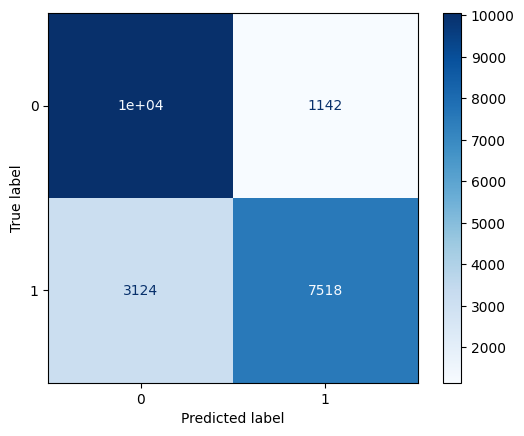

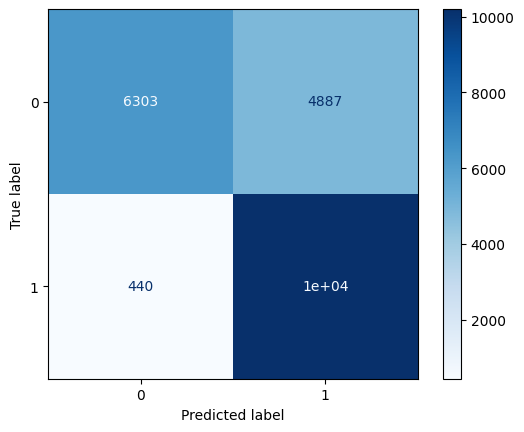

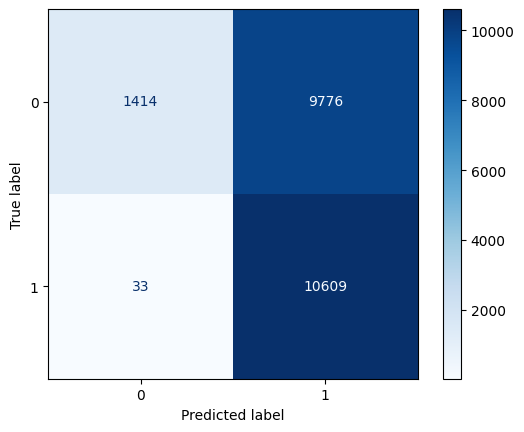

In [ ]:
# Threshold values
for ratio in [2/3, 3/4, 5/6]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2, gpt2, ratio)

We will now test different GPT-2 model versions with a threshold value of 2/3.

# GPT-2 Medium

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Precision: 0.9140350877192982
Recall: 0.5385265927457245
F1-score: 0.6777436140018921
              precision    recall  f1-score   support

   generated     0.6844    0.9518    0.7963     11190
       human     0.9140    0.5385    0.6777     10642

    accuracy                         0.7504     21832
   macro avg     0.7992    0.7452    0.7370     21832
weighted avg     0.7963    0.7504    0.7385     21832

[[10651   539]
 [ 4911  5731]]


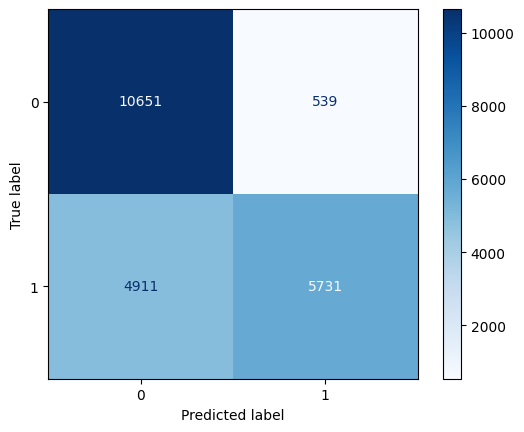

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2_medium = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)
tokenizer_gpt2_medium = AutoTokenizer.from_pretrained("gpt2-medium")
gpt2_medium.eval()
# Define start token
start_token = tokenizer_gpt2_medium(tokenizer_gpt2_medium.bos_token, return_tensors='pt').data['input_ids'][0]

# Threshold value at 2/3
test_model(test_dataset, tokenizer_gpt2_medium, gpt2_medium, 2/3)

# GPT-2 Large

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Precision: 0.9184131736526946
Recall: 0.46119150535613607
F1-score: 0.6140372826222945
              precision    recall  f1-score   support

   generated     0.6522    0.9610    0.7771     11190
       human     0.9184    0.4612    0.6140     10642

    accuracy                         0.7174     21832
   macro avg     0.7853    0.7111    0.6956     21832
weighted avg     0.7820    0.7174    0.6976     21832

[[10754   436]
 [ 5734  4908]]


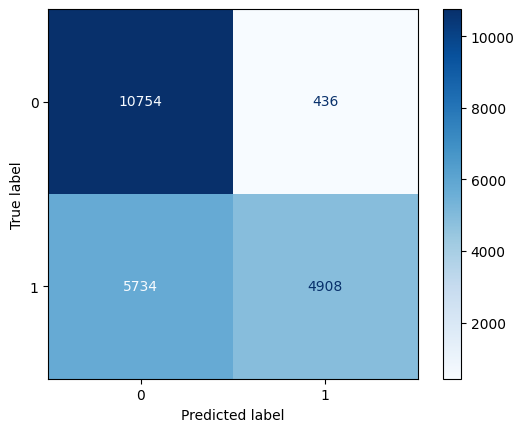

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2_large = AutoModelForCausalLM.from_pretrained("gpt2-large").to(device)
tokenizer_gpt2_large = AutoTokenizer.from_pretrained("gpt2-large")
gpt2_large.eval()
# Define start token
start_token = tokenizer_gpt2_large(tokenizer_gpt2_large.bos_token, return_tensors='pt').data['input_ids'][0]

# Threshold value at 2/3
test_model(test_dataset, tokenizer_gpt2_large, gpt2_large, 2/3)

# GPT-2 XL

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Precision: 0.9119258322798146
Recall: 0.4066904717158429
F1-score: 0.5625162464257863
              precision    recall  f1-score   support

   generated     0.6305    0.9626    0.7619     11190
       human     0.9119    0.4067    0.5625     10642

    accuracy                         0.6916     21832
   macro avg     0.7712    0.6847    0.6622     21832
weighted avg     0.7677    0.6916    0.6647     21832

[[10772   418]
 [ 6314  4328]]


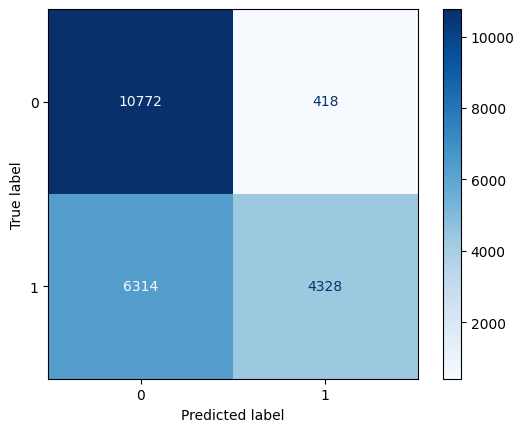

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2_xl = AutoModelForCausalLM.from_pretrained("gpt2-xl").to(device)
tokenizer_gpt2_xl = AutoTokenizer.from_pretrained("gpt2-xl")
gpt2_xl.eval()
# Define start token
start_token = tokenizer_gpt2_xl(tokenizer_gpt2_xl.bos_token, return_tensors='pt').data['input_ids'][0]

# Threshold value at 2/3
test_model(test_dataset, tokenizer_gpt2_xl, gpt2_xl, 2/3)

# **Conclusions**
**Best Threshold Value:**

 The best score for the Generated class is achieved at the threshold of 2/3, with an F1-score of 82.49%. While for the Human class, it is obtained at the threshold of 3/4, with an F1-score of 79.30%. Overall, the most optimal threshold value is 2/3, which returns the highest macro F1-score, 80,19%, by balancing the performance between the Generated and Human categories.


**Best GPT-2 Model:**

 We can notice that as the model size increases, the performance generally declines across all metrics: Generated F1-score, Human F1-score, and macro F1-score.  Hence, the best results are obtained with the `gpt2-small` model, with Generated F1-score, Human F1-score, and macro F1-score of 82.49%, 77.90%, and 80.19%, respectively.

 From the confusion matrix, we can see that out of 11,190 generated texts, the model correctly classifies 10,048 as generated (true positives). However, it misidentifies 1,142 as human-written (false positives). On the other hand, for the 10,642 human-written texts, the model classifies 7,518 as human, while misclassifying 3,124 as generated (false negatives). Although overall the model performs well, it still has room for improvement in distinguishing between generated and human-written texts, especially in reducing false positives and false negatives.

 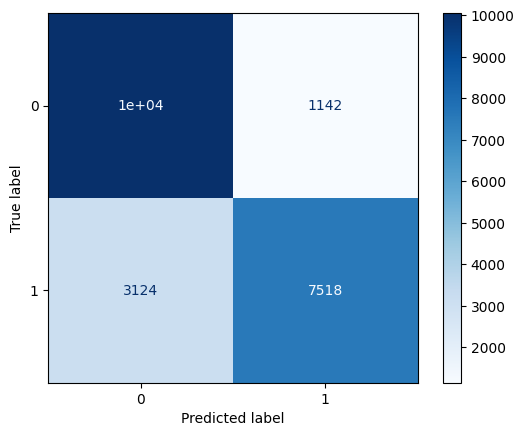